## Семинар 5: "Улучшение сходимости нейросетей"

ФИО: Евстифеев Степан Александрович

In [67]:
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import train_utils
import sys
%matplotlib inline

На этом семинаре мы попробуем улучшить результаты, полученные на предыдущем занятии
Для этого нам понадобятся следующие вещи:
* Dropout
* Batch Normalization
* Инициализация весов

### Часть 1: Инициализация весов

На лекции доказывалось, что при инициализации He и Glorot дисперсия активаций градиентов в каждом слое будут примерно равны. Давайте проверим это. 

In [2]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

Processing...
Done!


In [3]:
images_train, labels_train = next(iter(train_loader))

In [4]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    pass

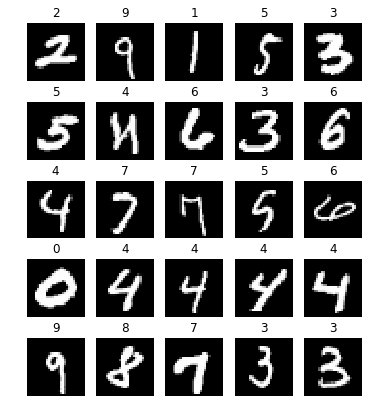

In [5]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

<i> 1.1 </i> Инициализируйте полносвязную сеть нормальным шумом N(0, 0.1) с архитектурой 784 -> 500 x (10 раз) -> 10. В качестве активации возьмите tanh

In [34]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=mean, std=std)

def init_layer_uniform(layer, low=0, high=1):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.uniform_(low, high)
    
def forward_hook(self, input_, output):
    std = input_[0].std().data[0]
    print ('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().data[0]
    print ('backward', std)

    
# пример:
layer = nn.Linear(28*28, 10)
layer.register_forward_hook(forward_hook)
layer.register_backward_hook(backward_hook)
init_layer(layer, 0.0, 0.1) # сюда надо подставить другие параметры

<i>1.2 Пропустите батч изображений через нейронную сеть и вычислите дисперсию активаций. Затем вычислите градиент и получите дисперсию градиентов. Сравните эти значения между собой для разных слоев.</i>

In [36]:
def new_linear_layer(input_size, output_size, mean, std, distr='normal'):
    layer = nn.Linear(input_size, output_size)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    if distr == 'normal':
        init_layer(layer, 0, 1)
    elif distr == 'xavier':
        bord = np.sqrt(6 / (input_size + output_size))
        init_layer_uniform(layer, -bord, bord)
    elif distr == 'he':
        init_layer(layer, 0, np.sqrt(2.0 / input_size))
    return layer

In [37]:
##### YOUR CODE HERE #####
layers = []
mean = 0
std = 0.1
layers.append(new_linear_layer(784, 500, mean=0, std=np.sqrt(2./500)))
layers.append(nn.ReLU())
for i in range(10):
    layers.append(new_linear_layer(500, 500, mean=0, std=np.sqrt(2./500)))
    layers.append(nn.ReLU())
layers.append(new_linear_layer(500, 10, mean=0, std=np.sqrt(2./10)))
layers.append(nn.LogSoftmax())
network = nn.Sequential(*layers)
network

Sequential(
  (0): Linear(in_features=784, out_features=500, bias=True)
  (1): ReLU()
  (2): Linear(in_features=500, out_features=500, bias=True)
  (3): ReLU()
  (4): Linear(in_features=500, out_features=500, bias=True)
  (5): ReLU()
  (6): Linear(in_features=500, out_features=500, bias=True)
  (7): ReLU()
  (8): Linear(in_features=500, out_features=500, bias=True)
  (9): ReLU()
  (10): Linear(in_features=500, out_features=500, bias=True)
  (11): ReLU()
  (12): Linear(in_features=500, out_features=500, bias=True)
  (13): ReLU()
  (14): Linear(in_features=500, out_features=500, bias=True)
  (15): ReLU()
  (16): Linear(in_features=500, out_features=500, bias=True)
  (17): ReLU()
  (18): Linear(in_features=500, out_features=500, bias=True)
  (19): ReLU()
  (20): Linear(in_features=500, out_features=500, bias=True)
  (21): ReLU()
  (22): Linear(in_features=500, out_features=10, bias=True)
  (23): LogSoftmax()
)

In [38]:
#пример:
n_objects = 100
X = Variable(images_train[:n_objects], requires_grad=False).view(n_objects, -1)
y = Variable(labels_train[:n_objects], requires_grad=False)
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(layer.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward tensor(1.0016)
forward tensor(16.4718)
forward tensor(246.2770)
forward tensor(3834.6794)
forward tensor(61759.3789)
forward tensor(995297.8750)
forward tensor(16279249.)
forward tensor(259331984.)
forward tensor(4106923008.)
forward tensor(60166053888.)
forward tensor(921640894464.)
forward tensor(14397463330816.)
backward tensor(0.0041)
backward tensor(0.0089)
backward tensor(0.1362)
backward tensor(2.1144)
backward tensor(32.1923)
backward tensor(514.4309)
backward tensor(8155.4185)
backward tensor(134601.9062)
backward tensor(2091512.)
backward tensor(32467822.)
backward tensor(503084000.)
backward tensor(7922933248.)


/home/s.evstifeev/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  from ipykernel import kernelapp as app
/home/s.evstifeev/anaconda3/lib/python3.6/site-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/s.evstifeev/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


<i>1.3 Повторите эксперимент для инициализаций He и Xavier (формулы есть в лекции).</i>

In [55]:
def new_linear_layer(input_size, output_size, mean, std, distr='normal'):
    layer = nn.Linear(input_size, output_size)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    if distr == 'normal':
        init_layer(layer, 0, 1)
    elif distr == 'xavier':
        bord = np.sqrt(6.0 / (input_size + output_size))
        init_layer_uniform(layer, low=-bord, high=bord)
    elif distr == 'he':
        init_layer(layer, 0, np.sqrt(2 / output_size))
    return layer

In [56]:
def test_init(distr='normal'):
    layers = []
    mean = 0
    std = 0.1
    layers.append(new_linear_layer(784, 500, mean=0, std=np.sqrt(2./500), distr=distr))
    layers.append(nn.ReLU())
    
    for i in range(10):
        layers.append(new_linear_layer(500, 500, mean=0, std=np.sqrt(2./500), distr=distr))
        layers.append(nn.ReLU())
        
    layers.append(new_linear_layer(500, 10, mean=0, std=np.sqrt(2./10),  distr=distr))
    layers.append(nn.LogSoftmax())
    network = nn.Sequential(*layers)
    n_objects = 100
    X = Variable(images_train[:n_objects], requires_grad=False).view(n_objects, -1)
    y = Variable(labels_train[:n_objects], requires_grad=False)
    activations = network(X)
    loss_fn = torch.nn.NLLLoss()
    optimizer = torch.optim.Adam(layer.parameters(), lr=0.001) 
    loss = loss_fn(activations, y)
    loss.backward()

In [59]:
test_init('normal')

/home/s.evstifeev/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  from ipykernel import kernelapp as app
/home/s.evstifeev/anaconda3/lib/python3.6/site-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/s.evstifeev/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


forward tensor(1.0016)
forward tensor(16.3525)
forward tensor(253.3283)
forward tensor(4099.7295)
forward tensor(68542.0547)
forward tensor(1082778.2500)
forward tensor(15846507.)
forward tensor(242392192.)
forward tensor(4235630336.)
forward tensor(70651371520.)
forward tensor(1106712330240.)
forward tensor(18123648401408.)
backward tensor(0.0042)
backward tensor(0.0093)
backward tensor(0.1495)
backward tensor(2.3232)
backward tensor(39.2328)
backward tensor(634.9057)
backward tensor(9879.3887)
backward tensor(153919.6250)
backward tensor(2476965.)
backward tensor(40051524.)
backward tensor(635278848.)
backward tensor(9826892800.)


In [60]:
test_init('xavier')

forward tensor(1.0016)
forward tensor(0.6523)
forward tensor(0.4618)
forward tensor(0.3284)
forward tensor(0.2358)
forward tensor(0.1701)
forward tensor(0.1182)
forward tensor(0.0797)
forward tensor(0.0585)
forward tensor(0.0402)
forward tensor(0.0272)
forward tensor(0.0182)
backward tensor(0.0030)
backward tensor(0.0004)
backward tensor(0.0003)
backward tensor(0.0002)
backward tensor(0.0001)
backward tensor(0.0001)
backward tensor(0.0001)
backward tensor(0.0000)
backward tensor(0.0000)
backward tensor(0.0000)
backward tensor(0.0000)
backward tensor(0.0000)


/home/s.evstifeev/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  from ipykernel import kernelapp as app
/home/s.evstifeev/anaconda3/lib/python3.6/site-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/s.evstifeev/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


In [61]:
test_init('he')

forward tensor(1.0016)
forward tensor(1.0358)
forward tensor(1.0533)
forward tensor(1.0441)
forward tensor(1.0933)
forward tensor(1.1202)
forward tensor(1.1438)
forward tensor(1.1598)
forward tensor(1.1176)
forward tensor(1.1101)
forward tensor(1.0163)
forward tensor(1.0516)
backward tensor(0.0042)
backward tensor(0.0043)
backward tensor(0.0043)
backward tensor(0.0044)
backward tensor(0.0043)
backward tensor(0.0043)
backward tensor(0.0043)
backward tensor(0.0043)
backward tensor(0.0044)
backward tensor(0.0043)
backward tensor(0.0043)
backward tensor(0.0043)


/home/s.evstifeev/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  from ipykernel import kernelapp as app
/home/s.evstifeev/anaconda3/lib/python3.6/site-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/s.evstifeev/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


<i> 1.4 Сделайте выводы по первой части </i>

Различия в функции инициализации:

**Инициализация N(0, 1)** - градиенты сразу же начинают взрываться.

**Xavier** - градиенты не взрывается, но к последнему слою начинают затухать.

**He** - градиенты на каждом слое сохраняются и имеют постоянную дисперсию.

### Часть 2: Dropout

Другим полезным слоем является Dropout. В нем с вероятностью 1-p зануляется выход каждого нейрона. Этот слой уже реализован в pyTorch, поэтому вновь реализовывать его не интересно. Давайте реализуем DropConnect — аналог Dropout. В нем с вероятностью 1-p зануляется каждый вес слоя.

<i> 2.1 Реализуйте линейный слой с DropConnect </i>

In [96]:
def train_cuda(network, train_loader, test_loader, epochs, learning_rate, ravel_init=False, on_cuda=True, 
               device="cuda"):
    loss = nn.NLLLoss().cuda() if on_cuda else nn.NLLLoss()
    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            network.train()
            for X, y in train_loader:
                X = Variable(X)
                if ravel_init:
                    X = X.view(X.size(0), -1)
                y = Variable(y)
                if on_cuda:
                    X, y = X.cuda(), y.cuda()
                network.zero_grad()
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.data[0])
                loss_batch.backward()
                optimizer.step()
                accuracies.append((np.argmax(prediction.cpu().data.numpy(), 1)==y.cpu().data.numpy()).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []  
            network.eval()
            for X, y in test_loader:
                X = Variable(X)
                if ravel_init:
                    X = X.view(X.size(0), -1)
                y = Variable(y)
                if on_cuda:
                    X, y = X.cuda(), y.cuda()
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.data[0])
                accuracies.append((np.argmax(prediction.cpu().data.numpy(), 1)==y.cpu().data.numpy()).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                        train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
    except KeyboardInterrupt:
        pass
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_epochs, label='Train')
    plt.plot(test_loss_epochs, label='Test')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid(True)
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy_epochs, label='Train accuracy')
    plt.plot(test_accuracy_epochs, label='Test accuracy')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid(True)
    plt.show()
    return train_loss_epochs, test_loss_epochs, train_accuracy_epochs, test_accuracy_epochs

/home/s.evstifeev/anaconda3/lib/python3.6/site-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/s.evstifeev/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/s.evstifeev/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 19... (Train/Test) NLL: 0.008/0.094	Accuracy: 0.997/0.982

/home/s.evstifeev/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


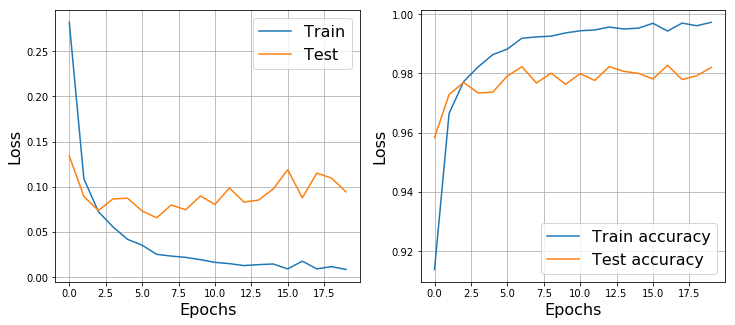

In [78]:
network = nn.Sequential(nn.Linear(784, 200),
                        nn.ReLU(),
                        nn.Linear(200, 200),
                        nn.ReLU(),
                        nn.Linear(200, 10),
                        nn.LogSoftmax())

train_l_l, test_l_l, train_a_l, test_a_l =  train_cuda(network.cuda(), train_loader, test_loader, 20, 0.001, ravel_init=True)

/home/s.evstifeev/anaconda3/lib/python3.6/site-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/s.evstifeev/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/s.evstifeev/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 19... (Train/Test) NLL: 0.101/0.074	Accuracy: 0.968/0.979

/home/s.evstifeev/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


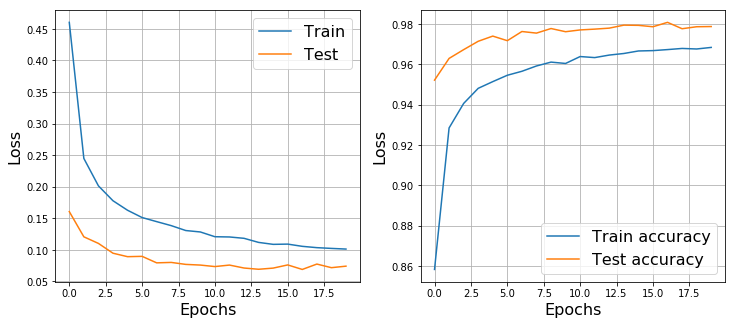

In [79]:
network = nn.Sequential(nn.Linear(784, 200),
                        nn.Dropout(0.5),
                        nn.ReLU(),
                        nn.Linear(200, 200),
                        nn.Dropout(0.5),
                        nn.ReLU(),
                        nn.Linear(200, 10),
                        nn.LogSoftmax())


train_l_do, test_l_do, train_a_do, test_a_do = train_cuda(network.cuda(), 
                                                      train_loader, test_loader, 20, 0.001, ravel_init=True)

In [80]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5, mean=0, std=0.01):
        super(DropConnect, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(input_dim, output_dim).normal_(mean=mean, std=std), requires_grad=True)
        self.bias = nn.Parameter(torch.Tensor(1, output_dim).zero_(), requires_grad=True)
        self.p = p

    def forward(self, x):
        if self.training:
            mask = torch.zeros(self.weight.size())+(1-self.p)
            mask = torch.bernoulli(mask)
        else:
            mask = torch.ones(self.weight.size())*self.p
        mask = Variable(mask, requires_grad=False).cuda()
        output = torch.mm(x, self.weight*mask)+self.bias
        return output

/home/s.evstifeev/anaconda3/lib/python3.6/site-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/s.evstifeev/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/s.evstifeev/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 19... (Train/Test) NLL: 0.057/0.063	Accuracy: 0.981/0.982

/home/s.evstifeev/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


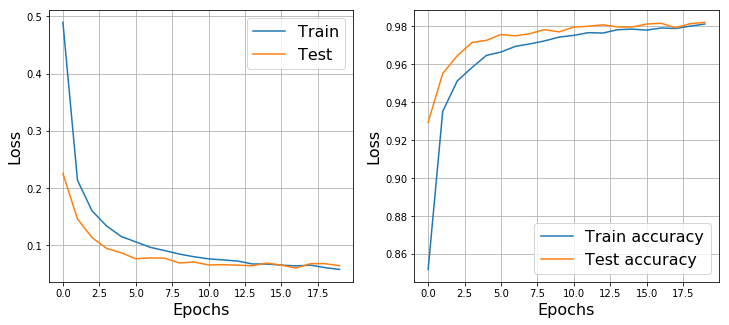

In [81]:
network = nn.Sequential(DropConnect(784, 200, p=0.5),
                        nn.ReLU(),
                        DropConnect(200, 200, p=0.5),
                        nn.ReLU(),
                        nn.Linear(200, 10),
                        nn.LogSoftmax())

train_l_dc, test_l_dc, train_a_dc, test_a_dc = train_cuda(network.cuda(), train_loader, test_loader, 20, 0.001, ravel_init=True)

<i> 
2.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с ReLU и Dropout между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с ReLU DropConnect вместо всех линейных слоев
</i>

In [ ]:
train_l_l, test_l_l, train_a_l, test_a_l

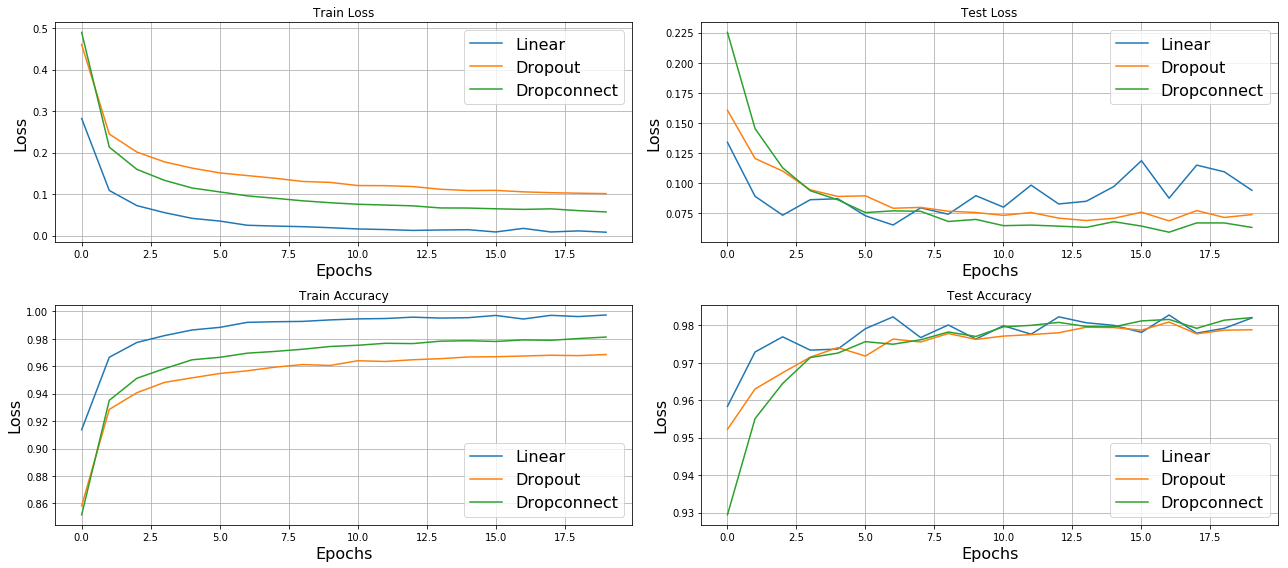

In [93]:
plt.figure(figsize=(18, 8))
plt.subplot(2, 2, 1)
plt.plot(train_l_l, label='Linear')
plt.plot(train_l_do, label='Dropout')
plt.plot(train_l_dc, label='Dropconnect')
plt.title("Train Loss")
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(test_l_l, label='Linear')
plt.plot(test_l_do, label='Dropout')
plt.plot(test_l_dc, label='Dropconnect')
plt.title("Test Loss")
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(train_a_l, label='Linear')
plt.plot(train_a_do, label='Dropout')
plt.plot(train_a_dc, label='Dropconnect')
plt.title("Train Accuracy")
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(test_a_l, label='Linear')
plt.plot(test_a_do, label='Dropout')
plt.plot(test_a_dc, label='Dropconnect')
plt.title("Test Accuracy")
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid(True)

plt.tight_layout()

<i> 2.3 Сделайте выводы по третьей части </i>

**Выводы**:

Архитектура без dropout переобучается. Dropout\Dropconnect позволяют предотвратить это, но в ущерб скорости сходимости. Dropconnect при этом сходиться быстрее dropout и к более высокой точности (0.98);

В test-time стохастичность Dropout убирают и заменяют все веса на их ожидаемое значение: $\mathbb{E}w = pw + (1-p)0 = pw$.

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

<i> 3.1 Реализуйте Layer Normalization </i>

In [99]:
# полезные функции: .std(dim), .mean(dim)

class LayerNormalization(nn.Module):
    
    def __init__(self, input_dim):
        super(LayerNormalization, self).__init__()
        self.g = nn.Parameter(torch.cuda.FloatTensor(input_dim).fill_(1), requires_grad=True)
        self.bias = nn.Parameter(torch.cuda.FloatTensor(input_dim).fill_(0.1), requires_grad=True)
        
    def forward(self, x):
        output = self.g * (x - x.mean() / x.std()) + self.bias
        return output

<i> 
3.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с ReLU и Batch normalization между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с ReLU и Layer normalization между всеми слоями 
</i>

/home/s.evstifeev/anaconda3/lib/python3.6/site-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/s.evstifeev/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/s.evstifeev/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 19... (Train/Test) NLL: 0.011/0.086	Accuracy: 0.996/0.980

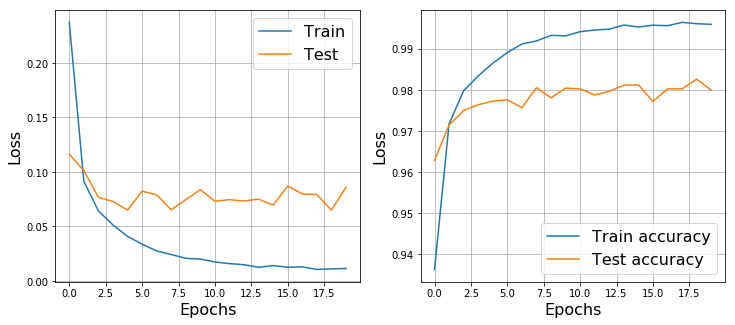

In [98]:
network = nn.Sequential(nn.Linear(784, 200),
                        nn.ReLU(),
                        nn.BatchNorm1d(200),
                        nn.Linear(200, 200),
                        nn.ReLU(),
                        nn.BatchNorm1d(200),
                        nn.Linear(200, 10),
                        nn.LogSoftmax())

train_l_bn, test_l_bn, train_a_bn, test_a_bn = train_cuda(network.cuda(), train_loader, test_loader, 20, 0.001, ravel_init=True)

/home/s.evstifeev/anaconda3/lib/python3.6/site-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/s.evstifeev/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/s.evstifeev/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 19... (Train/Test) NLL: 0.007/0.102	Accuracy: 0.998/0.979

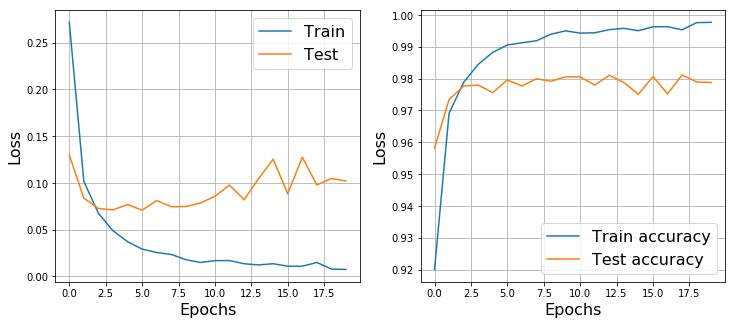

In [100]:
network = nn.Sequential(nn.Linear(784, 200),
                        nn.ReLU(),
                        LayerNormalization(200),
                        nn.Linear(200, 200),
                        nn.ReLU(),
                        LayerNormalization(200),
                        nn.Linear(200, 10),
                        nn.LogSoftmax())
train_l_ln, test_l_ln, train_a_ln, test_a_ln = train_cuda(network.cuda(), train_loader, test_loader, 20, 0.001, ravel_init=True)

<i> 3.3 Сделайте выводы по третьей части </i>

С Batch norm и Layer Normalization сеть сходиться чуть быстрее, чем без нормализации, но она также подвержена переобучению.

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: